## Titanic survival
### Dataset
We might have all heard about the sinking of the 'Titanic' in 1912 four days into her maiden voyage. There exists a dataset of the passengers including the information if the passengers survived or died. 
### Goal
Goal of this project is to predict survival of the passengers based on the data in the dataset. This means it is a **classification** supervised learning project. The predictions of the models to be created will be '1' for survived passengers or '0' for passengers who died.
### Models
We will try and compare different models and we will also use parameter search and cross validation.
### Why this dataset?
I choose the Titanic dataset because it is easily understandable to everyone and everyone has some kind of intuition about the dataset. E.g. the motto 'women and children first' might have an influence on the probability of survival or maybe first class passengers had priority to get into the life boats. So no background knowledge is required to understand the dataset itself.

Since the dataset itself is very understandable we can focus on EDA techniques and model generation.

### Link to the dataset
The dataset is from the famous kaggle platform and it used for public competition.
https://www.kaggle.com/competitions/titanic/data
### Size of the dataset
Kaggle split the dataset into two parts. A training dataset with 891 rows and a test dataset with 418 rows. The test dataset does not have the column 'Survived' as the survival is what needs to be predicted.
### Short description of the columns
There are 12 columns:
- PassengerId: As the name says just an identifier
- Survived: Whether the passenger survived or not
- Pclass: Passenger classes from 1 to 3. Similar to classes in airplanes nowadays, class 1 is the most expensive.
- Name: Name of the passenger. Contains not only first and last name but also a title, like 'Mr'.
- Sex: male or female
- Age: Age of the passenger
- SibSp: Number of siblings and/or spouses
- Parch: Number of parents and/or children
- Ticket: Ticket number
- Fare: Fare paid by the passenger
- Cabin: Cabin number.
- Embarked: Port where the passenger embarked. Cherbourg (France), Queenstown (Ireland), Southampton (England)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.model_selection import train_test_split  
from sklearn.svm import SVC  
from sklearn.metrics import accuracy_score, classification_report  
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score  
from sklearn.tree import export_text 
from sklearn.tree import plot_tree 
from sklearn.linear_model import LogisticRegression  


train = pd.read_csv(r'C:\Users\chris\Downloads\supervised learning\titanic\train.csv')  # if you want to run my code add your local files here
test = pd.read_csv(r'C:\Users\chris\Downloads\supervised learning\titanic\test.csv')    # if you want to run my code add your local files here
numberOfPassengersTrain = len(train.index);
numberOfPassengersTest = len(test.index);
print(f"Number of rows train: {numberOfPassengersTrain}") 
print(f"Number of rows test: {numberOfPassengersTest}") 

Number of rows train: 891
Number of rows test: 418


In [2]:
def showData(colName, df):
    print("Distribution, absolute values")
    print(df[colName].value_counts(dropna=False) )
    print("===============================")
    print("Distribution, percentages")
    print(df[colName].value_counts(dropna=False,normalize=True) )
    survivedCount = df.groupby([colName, 'Survived'])['Survived'].count()  
    print("===============================")
    print("Survival in absolute numbers")
    print(survivedCount)
    print("===============================")
    print("Survival in percent")
    percentage = survivedCount.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    percentage = percentage.reset_index(allow_duplicates=True)
    percentage = percentage.iloc[:, 1:] 
    print(percentage)
    if  df[colName].isnull().any():
        print("===============================")
        print("How many percent of the nan entries survived?")
        print(train[train[colName].isna()]['Survived'].value_counts(normalize=True,dropna=False) )
        
def GetMaxInformationFromColumns(df): # Overfitting a random forrest to check the amount of information in the columns
    x=df[df.columns[1:]]
    y=df[df.columns[:1]]
    y=y.values.ravel() # avoids error message: A column-vector y was passed when a 1d array was expected.
    model=RandomForestClassifier(n_estimators=1000)
    rf_classifier = model.fit(x,y)
    prediction=model.predict(x)
    print('The accuracy of the random forrest is',accuracy_score(prediction,y))

Let's have a look at the data set...

In [45]:
print(train.info())
print(train.head())

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 231 to 80
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           623 non-null    float64
 1   SibSp         623 non-null    int64  
 2   Parch         623 non-null    int64  
 3   Fare          623 non-null    float64
 4   Sex_female    623 non-null    bool   
 5   Sex_male      623 non-null    bool   
 6   Title_Dr      623 non-null    bool   
 7   Title_Master  623 non-null    bool   
 8   Title_Miss    623 non-null    bool   
 9   Title_Mr      623 non-null    bool   
 10  Title_Mrs     623 non-null    bool   
 11  Pclass_1      623 non-null    bool   
 12  Pclass_2      623 non-null    bool   
 13  Pclass_3      623 non-null    bool   
 14  Deck_A        623 non-null    bool   
 15  Deck_B        623 non-null    bool   
 16  Deck_C        623 non-null    bool   
 17  Deck_D        623 non-null    bool   
 18  Deck_E        623 non-null    bool

There are values missing in columns 'Embarked', 'Age' and especially 'Cabin' which has has mostly NAN values. I will replace the missing values with the most likely choice of existing values. The two passenger with no 'Embarked' value survived so let's assign them the embarkment with the highest probability of survival, which is 'C'.

In [4]:
showData("Embarked", train)
train['Embarked'] = train['Embarked'].fillna('C') 

Distribution, absolute values
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64
Distribution, percentages
Embarked
S      0.722783
C      0.188552
Q      0.086420
NaN    0.002245
Name: proportion, dtype: float64
Survival in absolute numbers
Embarked  Survived
C         0            75
          1            93
Q         0            47
          1            30
S         0           427
          1           217
Name: Survived, dtype: int64
Survival in percent
  Embarked  Survived   Survived
0        C         0  44.642857
1        C         1  55.357143
2        Q         0  61.038961
3        Q         1  38.961039
4        S         0  66.304348
5        S         1  33.695652
How many percent of the nan entries survived?
Survived
1    1.0
Name: proportion, dtype: float64


As far as I can see all the names following a particular pattern, e.g. 'Allen, Mr. William Henry'. This means we can extract a title which is always between a semicolon and a colon.

Since there are so many passengers without cabin information we mark those with cabin 'X', meaning no cabin information available. That will be later useful for the regression. Cabins seem to start with a letter followed by a number. We can create a new column 'Deck' with only the letter.

In [5]:
column_contains_dot = train['Name'].str.contains('.', regex=False).all()  # Titles always end with a dot in the data set, see above
train['Title'] = train['Name'].str.split(',').str[1].str.split('.').str[0].str.strip() # Extract title from Name column

train['Deck'] = train['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'X') # X means no Cabin
showData('Deck', train )

Distribution, absolute values
Deck
X    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64
Distribution, percentages
Deck
X    0.771044
C    0.066218
B    0.052750
D    0.037037
E    0.035915
A    0.016835
F    0.014590
G    0.004489
T    0.001122
Name: proportion, dtype: float64
Survival in absolute numbers
Deck  Survived
A     0             8
      1             7
B     0            12
      1            35
C     0            24
      1            35
D     0             8
      1            25
E     0             8
      1            24
F     0             5
      1             8
G     0             2
      1             2
T     0             1
X     0           481
      1           206
Name: Survived, dtype: int64
Survival in percent
   Deck  Survived    Survived
0     A         0   53.333333
1     A         1   46.666667
2     B         0   25.531915
3     B         1   74.468085
4     C         0   40.677966
5     C         1   5

I already extracted information from Cabin and Name, so I do not need those columns any more. Ticket number and passender id most likely cannot help calculate survival.

In [6]:
train = train.drop(columns=['Cabin', 'Name', "Ticket", "PassengerId"])

Let's have a closer look at the 'Age' column. Most passengers with no age information have the title 'Mr', that does not really help us at the moment. As expected masters are young boys (mean age 4.5 years).

In [7]:
missing_age_df = train[train['Age'].isna()] 
missing_age_titles = missing_age_df['Title'].value_counts()
print(missing_age_titles) 
print(train.groupby('Title')['Age'].mean())



Title
Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: count, dtype: int64
Title
Capt            70.000000
Col             58.000000
Don             40.000000
Dr              42.000000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           4.574167
Miss            21.773973
Mlle            24.000000
Mme             24.000000
Mr              32.368090
Mrs             35.898148
Ms              28.000000
Rev             43.166667
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64


For the passengers with no age information I will apply the mean age of the group with the same title.

In [8]:
train.loc[(train.Age.isnull())&(train.Title=='Mr'),'Age']=32
train.loc[(train.Age.isnull())&(train.Title=='Mrs'),'Age']=36
train.loc[(train.Age.isnull())&(train.Title=='Master'),'Age']=5
train.loc[(train.Age.isnull())&(train.Title=='Miss'),'Age']=22
train.loc[(train.Age.isnull())&(train.Title=='Dr'),'Age']=42

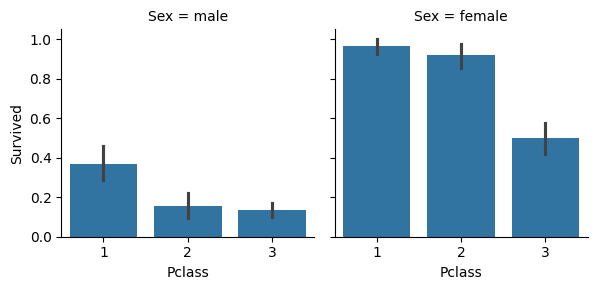

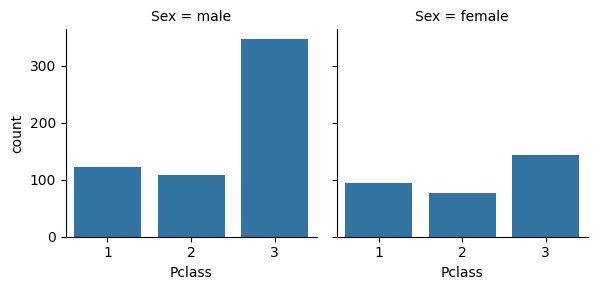

In [9]:
sns.catplot(data=train, x="Pclass", y="Survived", col="Sex", kind="bar", height=3, aspect=1)
sns.catplot(data=train, x="Pclass", col="Sex", kind="count", height=3, aspect=1)


We can draw the following conclusions:
- Females in class 1 and 2 nearly all survived.
- Half of the females in class 3 survived. So we need to find another criteria for survival of women in class 3.
- More than 80% of the males in class 2 and 3 died. So for men in class 1 we need to find another criteria.


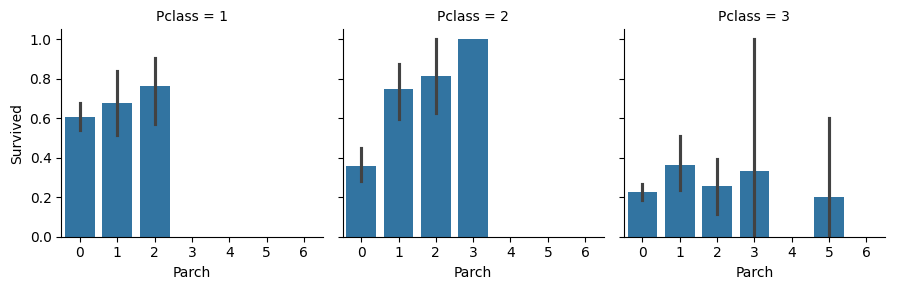

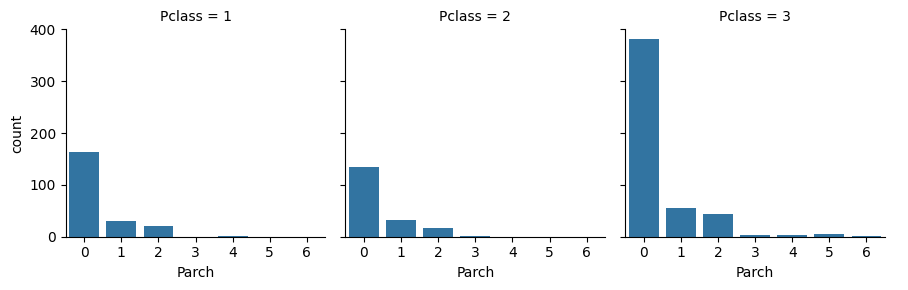

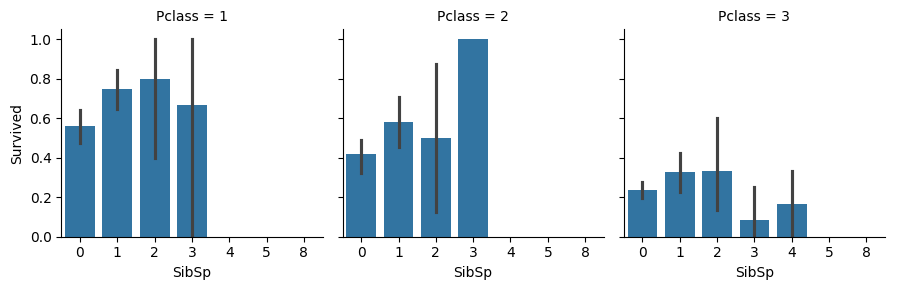

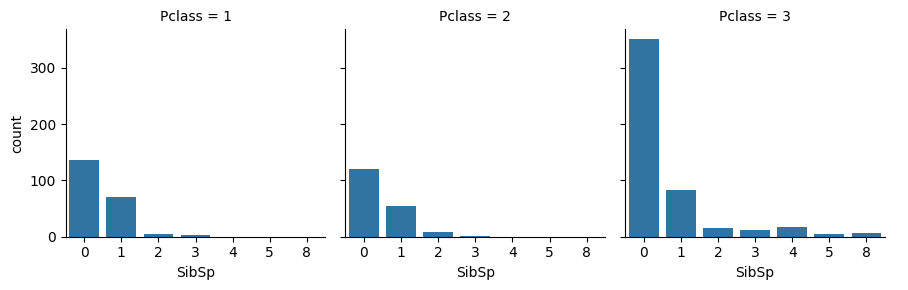

In [10]:
sns.catplot(data=train, x="Parch", y="Survived", col="Pclass", kind="bar", height=3, aspect=1)
sns.catplot(data=train, x="Parch", col="Pclass", kind="count", height=3, aspect=1)
sns.catplot(data=train, x="SibSp", y="Survived", col="Pclass", kind="bar", height=3, aspect=1)
sns.catplot(data=train, x="SibSp", col="Pclass", kind="count", height=3, aspect=1)

Generally SibSp and Parch are not helpful at the moment. We need to dig deeper into those, which means looking at those columns depending on Sex or Pclass.

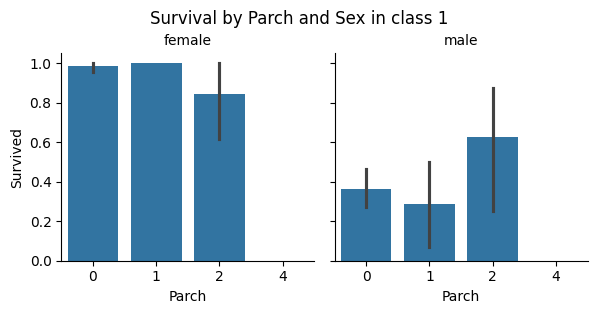

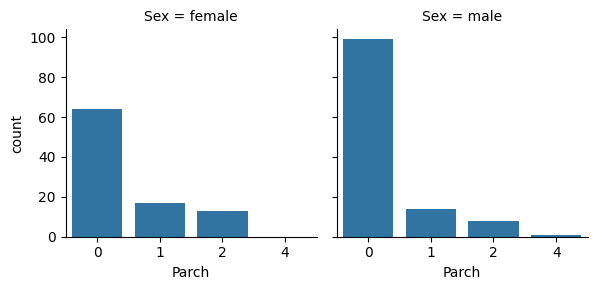

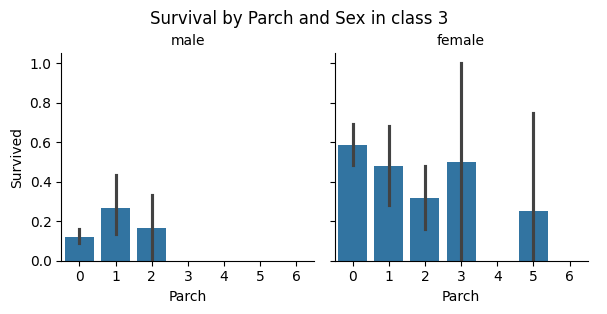

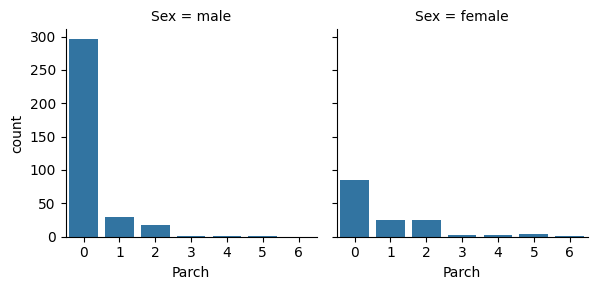

In [11]:
p = sns.catplot(data=(train[train.Pclass==1]), x="Parch", y="Survived", col="Sex", kind="bar", height=3, aspect=1)
p.set_titles("{col_name}")  
p.fig.suptitle("Survival by Parch and Sex in class 1", y=1.03) 
sns.catplot(data=train[train.Pclass==1], x="Parch", col="Sex", kind="count", height=3, aspect=1)
p = sns.catplot(data=(train[train.Pclass==3]), x="Parch", y="Survived", col="Sex", kind="bar", height=3, aspect=1)
p.set_titles("{col_name}")  
p.fig.suptitle("Survival by Parch and Sex in class 3", y=1.03) 
sns.catplot(data=train[train.Pclass==3], x="Parch", col="Sex", kind="count", height=3, aspect=1)

- Females in class 1 with Parch values of 0 or 1 nearly all survived.
- Males in class 1 with 2 parents/children had a 60:40 chance.
- Males in class 3 without any parent or children had very low probability of survival.

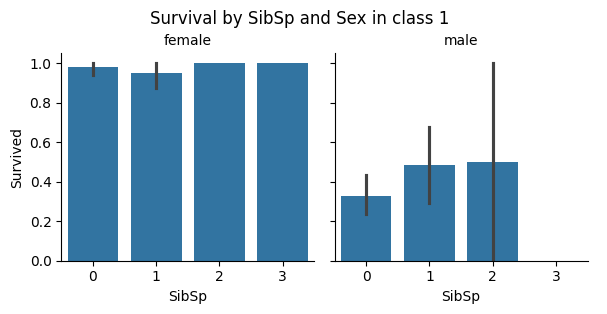

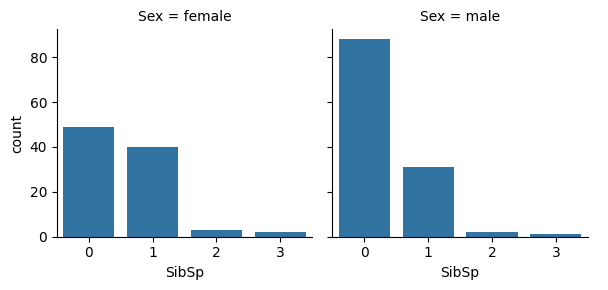

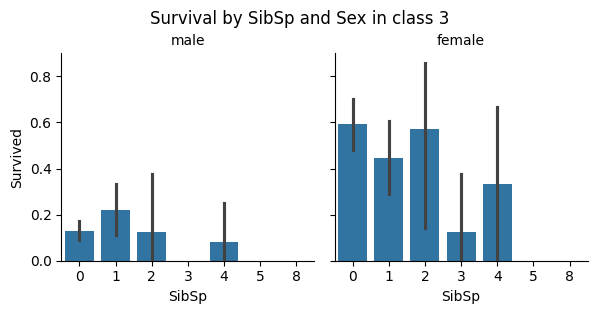

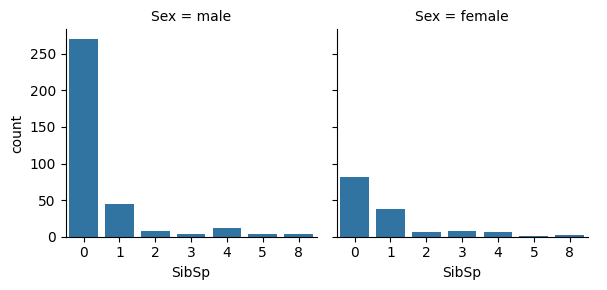

In [12]:
p = sns.catplot(data=(train[train.Pclass==1]), x="SibSp", y="Survived", col="Sex", kind="bar", height=3, aspect=1)
p.set_titles("{col_name}")  
p.fig.suptitle("Survival by SibSp and Sex in class 1", y=1.03) 
sns.catplot(data=train[train.Pclass==1], x="SibSp", col="Sex", kind="count", height=3, aspect=1)
p = sns.catplot(data=(train[train.Pclass==3]), x="SibSp", y="Survived", col="Sex", kind="bar", height=3, aspect=1)
p.set_titles("{col_name}")  
p.fig.suptitle("Survival by SibSp and Sex in class 3", y=1.03) 
sns.catplot(data=train[train.Pclass==3], x="SibSp", col="Sex", kind="count", height=3, aspect=1)

- Like Parch, SibSp does not show any clear decision boundary for survival of men in class 1 or women in class 3 but we know that men in class 1 with 1 or 2 siblings/spouses had a 50:50 chance.
- There seems to be an outlier for women in class 3 with SibSp value of 3 but we have also only very few women with those attributes.

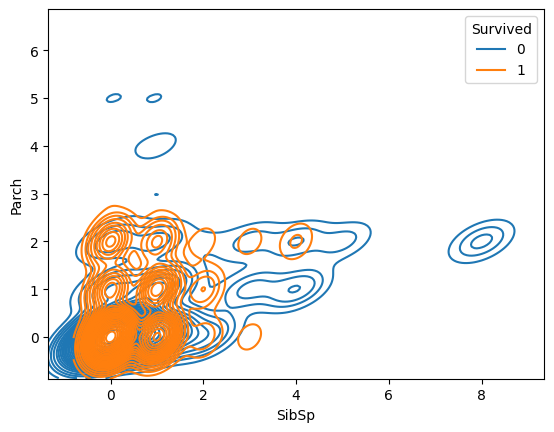

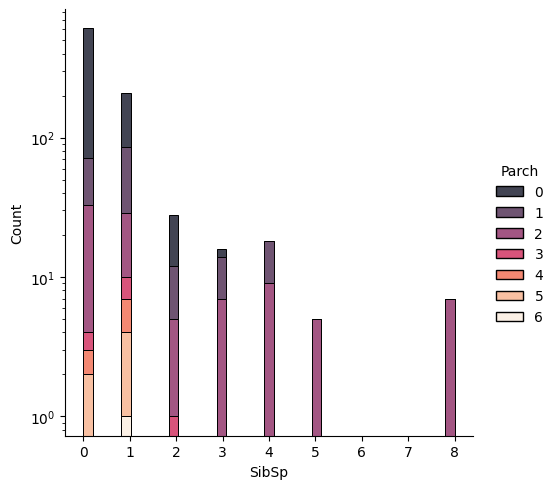

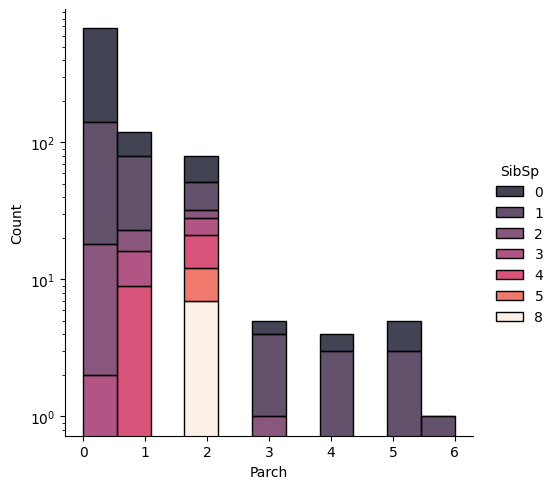

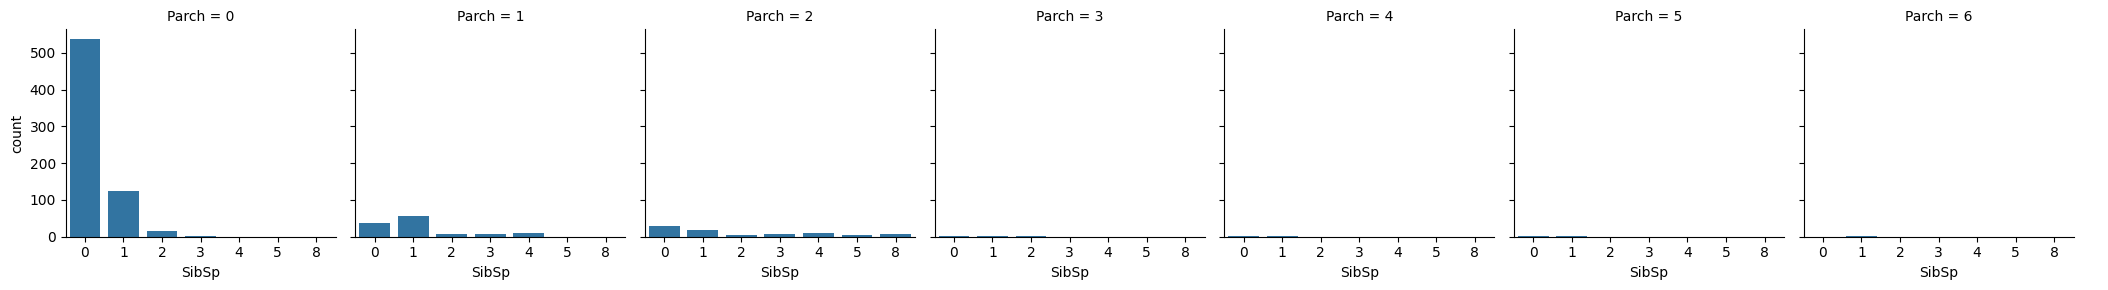

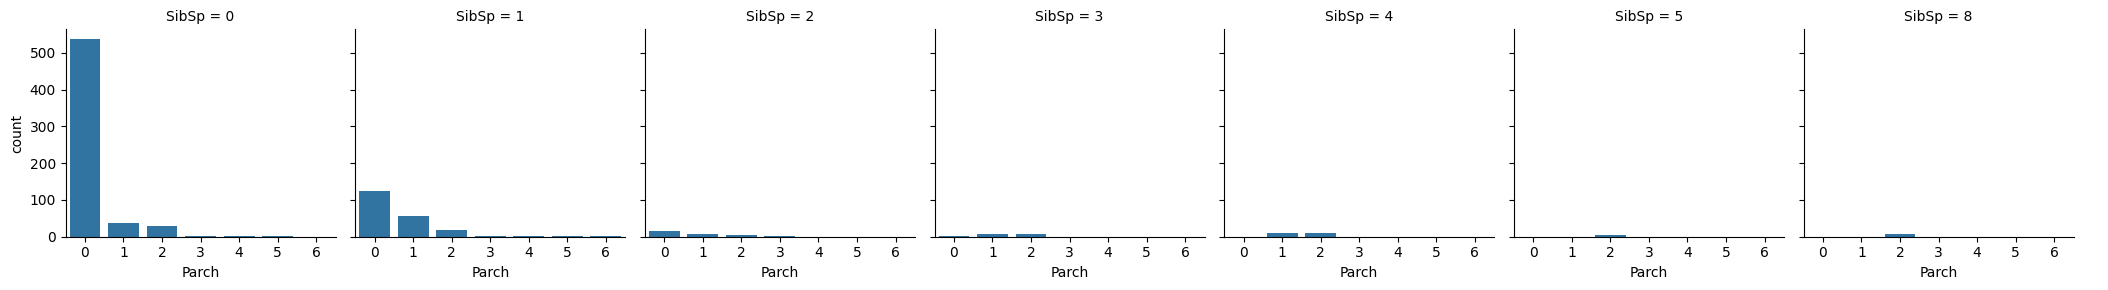

In [13]:
sns.kdeplot(data=train, x="SibSp", y="Parch", hue="Survived",levels=30, thresh=0)
sns.displot(data=train, x="SibSp", hue="Parch", multiple="stack", palette="rocket")
plt.yscale('log') 
plt.show()  
sns.displot(data=train, x="Parch", hue="SibSp", multiple="stack", palette="rocket")
plt.yscale('log') 
plt.show()  
sns.catplot(data=train, x="SibSp", col="Parch", kind="count", height=3, aspect=1)
sns.catplot(data=train, x="Parch", col="SibSp", kind="count", height=3, aspect=1)

The figures above show how Parch and SibSp are related. Please note it has a logarithmic y-axis. In the end most people travelled alone and we do not have enough data rows to draw big conclusions for Parch>0 and/or SibSp>0.

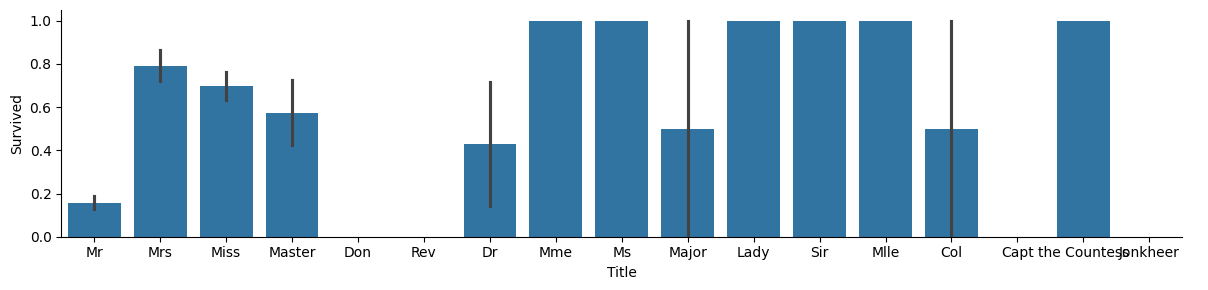

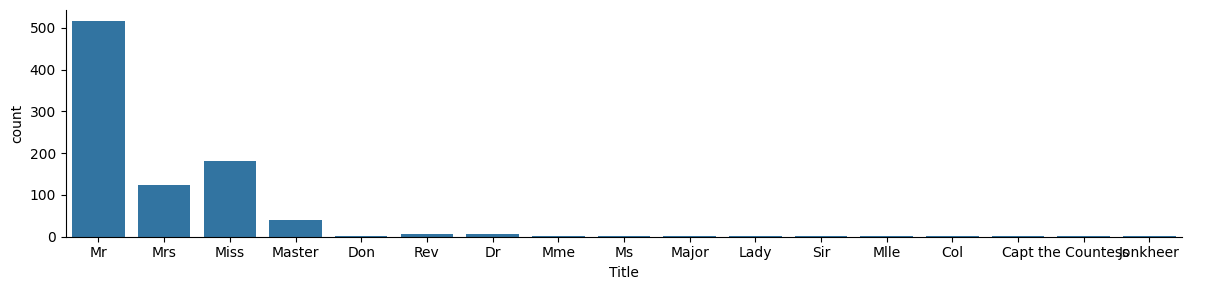

In [14]:
sns.catplot(data=train, x="Title", y="Survived", kind="bar", height=3, aspect=4)
sns.catplot(data=train, x="Title", kind="count", height=3, aspect=4)

- Males with the title 'Master', i.e. young males, had a 60:40 chance of survival.
- Major problem with the title 'Master' is that are not many data rows.

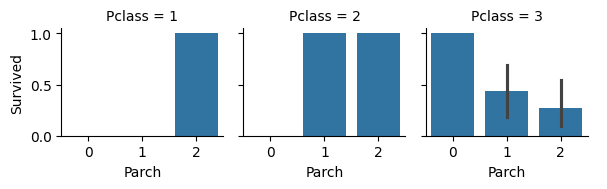

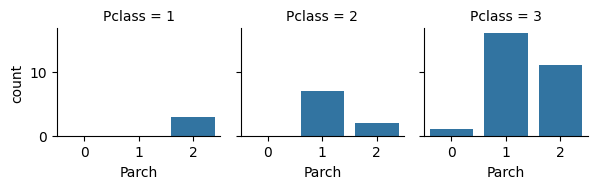

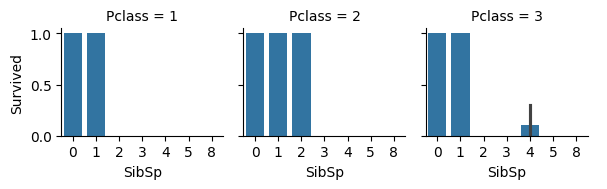

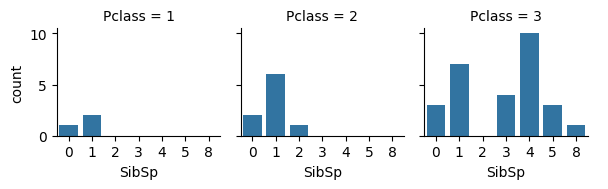

In [15]:
sns.catplot(data=train[train.Title=="Master"], x="Parch", y="Survived", col="Pclass",  kind="bar", height=2, aspect=1)
sns.catplot(data=train[train.Title=="Master"], x="Parch",  kind="count",col="Pclass",  height=2, aspect=1)
sns.catplot(data=train[train.Title=="Master"], x="SibSp", y="Survived", col="Pclass",  kind="bar", height=2, aspect=1)
sns.catplot(data=train[train.Title=="Master"], x="SibSp",  kind="count",col="Pclass",  height=2, aspect=1)

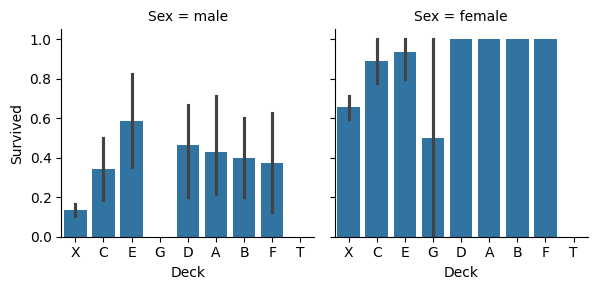

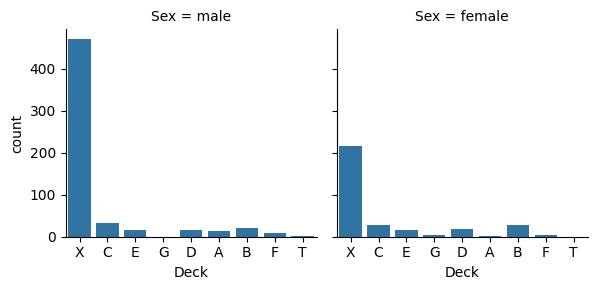

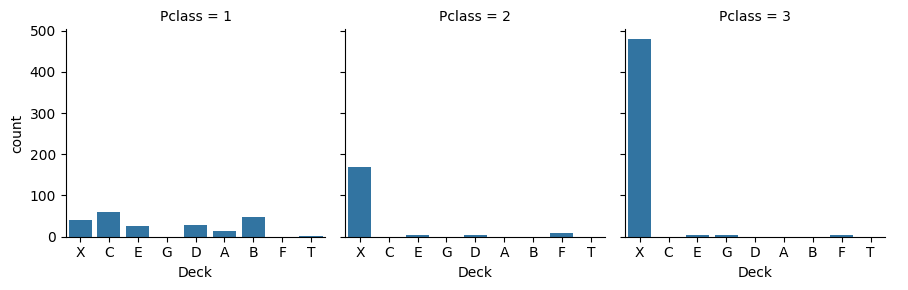

In [16]:
sns.catplot(data=train, x="Deck", y="Survived", col="Sex", kind="bar", height=3, aspect=1)
sns.catplot(data=train, x="Deck",  kind="count",col="Sex",  height=3, aspect=1)
sns.catplot(data=train, x="Deck", kind="count", col="Pclass", height=3, aspect=1)

- Round about 85% of all males without cabin number died
- More than 80% of all females with a cabin number survived (ignoring the outlier about deck 'G' which is statistically irrelevant because of the small data base)

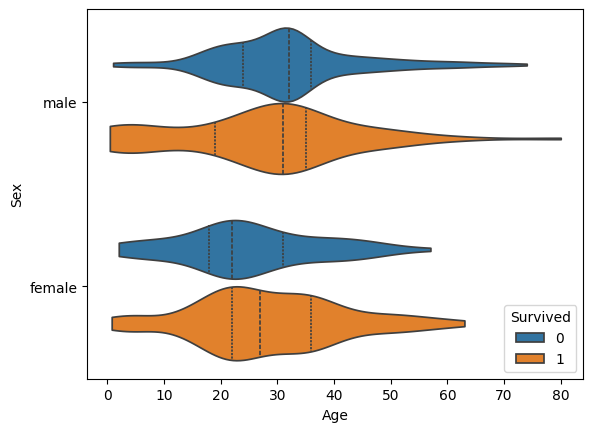

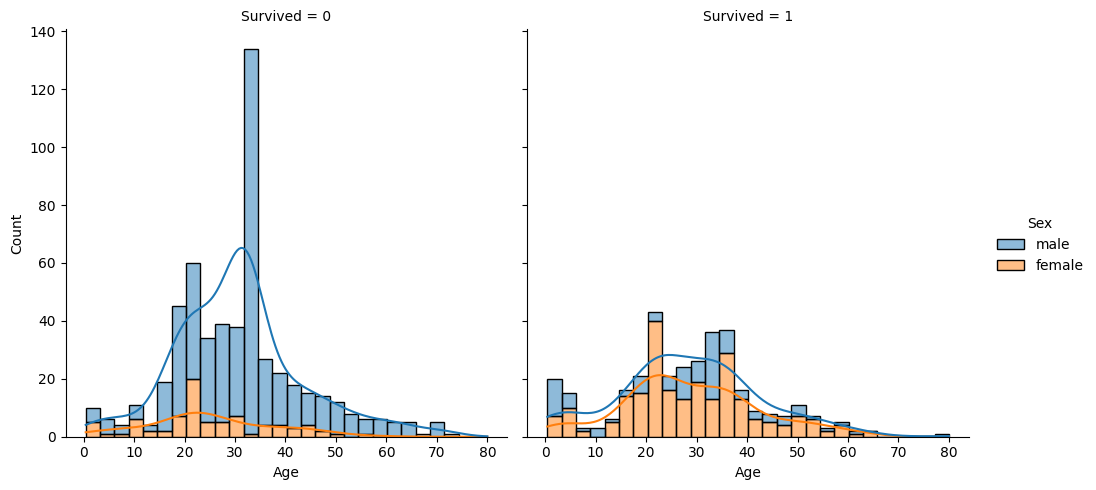

In [17]:
sns.violinplot(x="Age", y="Sex", hue="Survived",data=train,split=False,fill=True,cut=0, inner="quart")
sns.displot(data=train, x="Age", hue="Sex", col="Survived", kde=True,multiple="stack")


- Very young males had higher probability of survival.
- Nearly no women above 50 died

<Axes: xlabel='Age'>

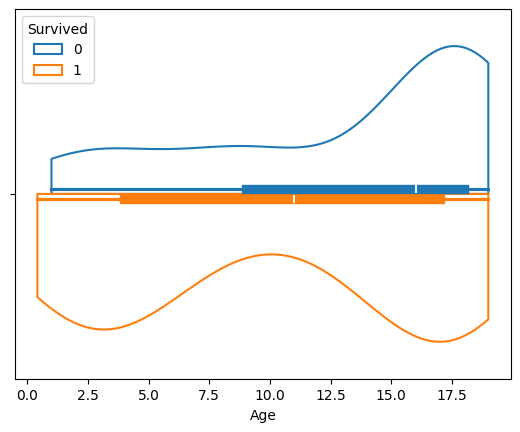

In [18]:
under20 =  train[train['Age'] < 20]
sns.violinplot(x="Age", hue="Survived",data=under20,split=True,fill=False,cut=0)

- Looking closer at the survival rate of young males we see especially males younger than 5 years had a significantly higher survival rate than older males.

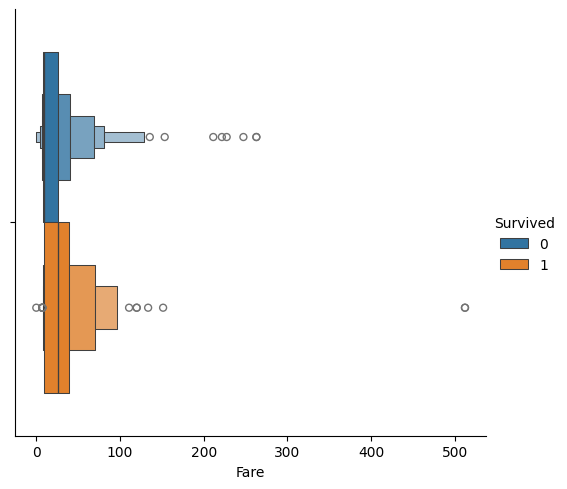

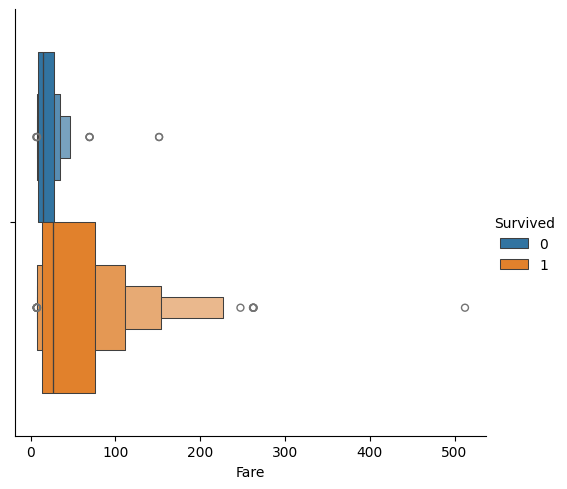

In [19]:
sns.catplot(data=train[train.Sex=='male'], x="Fare", hue="Survived", kind="boxen")
sns.catplot(data=train[train.Sex=='female'], x="Fare", hue="Survived", kind="boxen")

- Higher fare leads to higher survival rate in women, as one would expect. For men the fare does not seem to have much impact on survival.

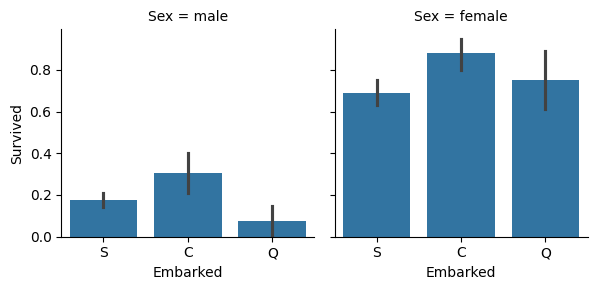

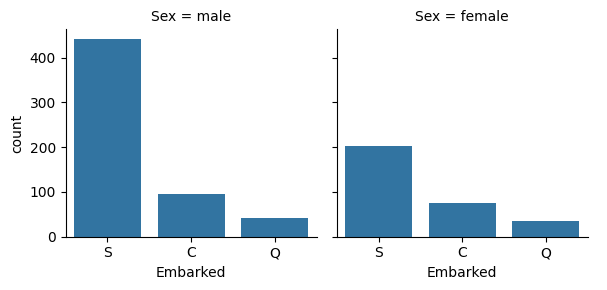

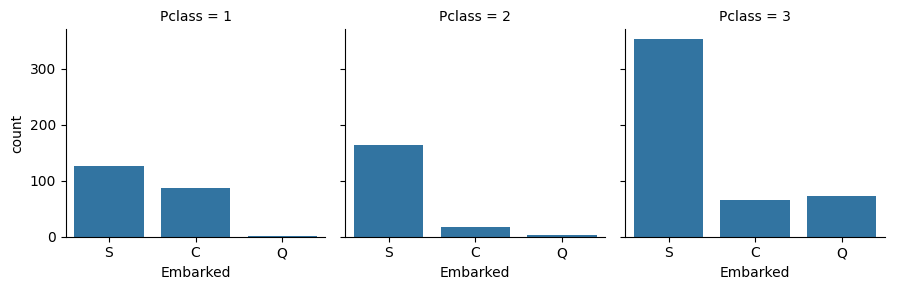

In [20]:
sns.catplot(data=train, x="Embarked", y="Survived", col="Sex", kind="bar", height=3, aspect=1)
sns.catplot(data=train, x="Embarked",  kind="count",col="Sex",  height=3, aspect=1)
sns.catplot(data=train, x="Embarked", kind="count", col="Pclass", height=3, aspect=1)

Most people who embarked in 'S' were class 3 passengers, so class 3 and embarkment 'S' are strongly related.

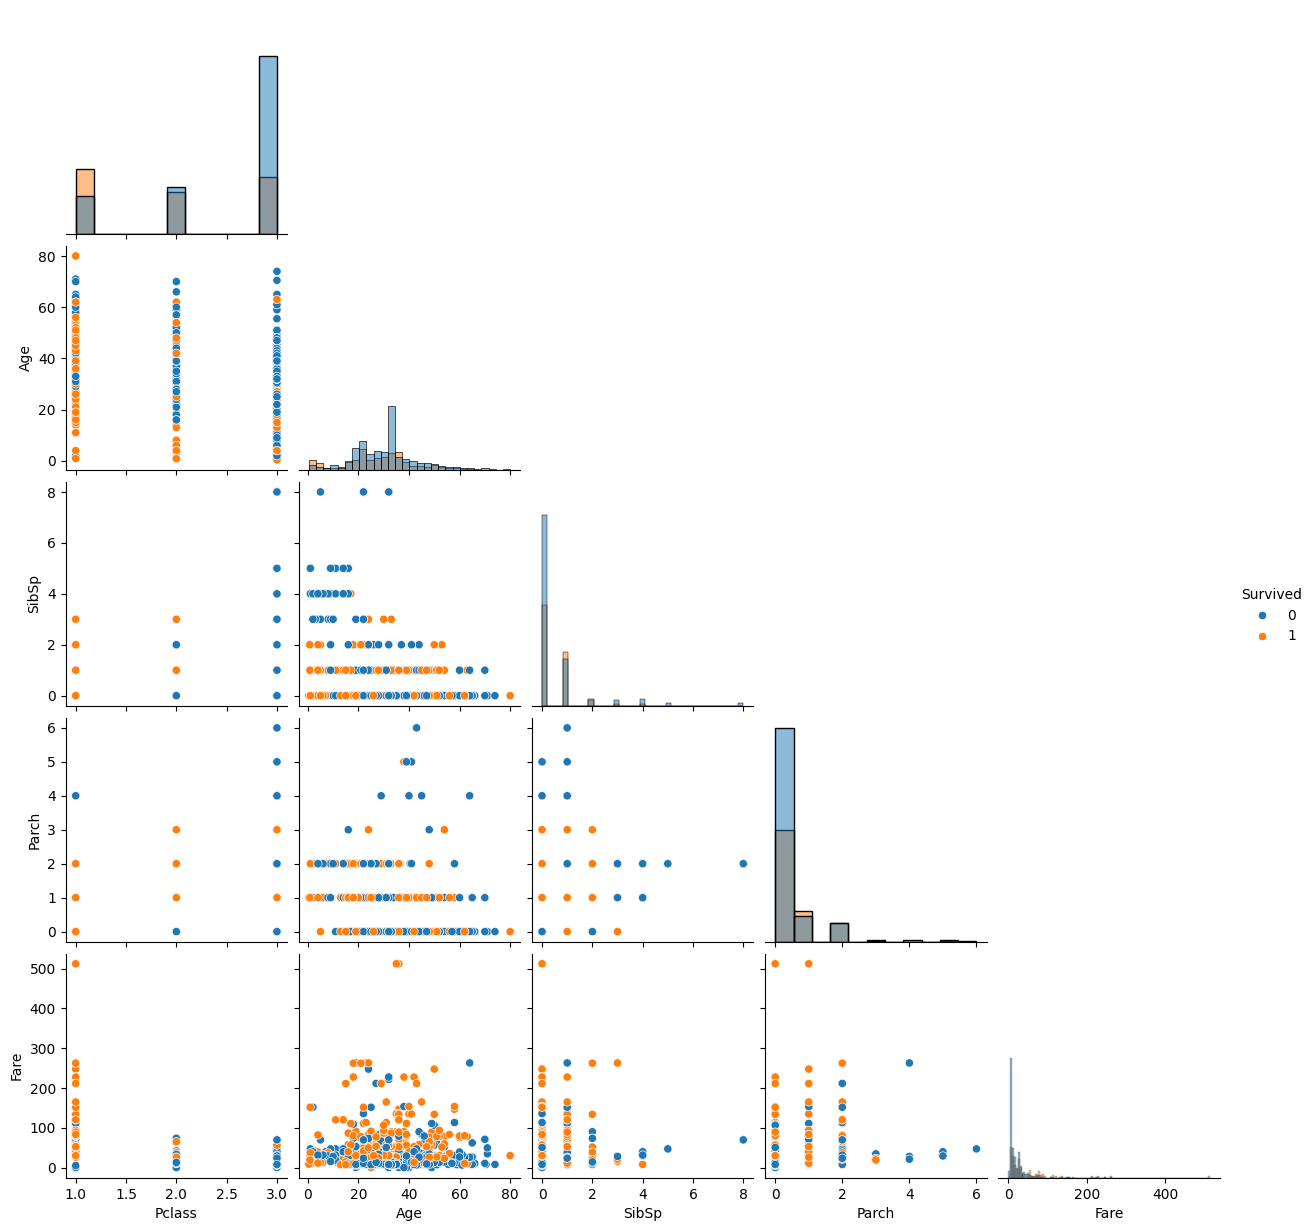

In [21]:
sns.pairplot(train, hue="Survived", diag_kind="hist",corner=True)

In [22]:
print("Overall survival in absolute numbers")
print(train['Survived'].value_counts(dropna=False) )
print("===============================")
print("Overall survival in percent")
print(train['Survived'].value_counts(normalize=True, dropna=False) ) 

Overall survival in absolute numbers
Survived
0    549
1    342
Name: count, dtype: int64
Overall survival in percent
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


So 61% of all passengers in our data set died. The most trivial estimator would be to estimate every one died which would be correct for 61% of the passengers in the training set.

In [23]:
showData("Sex", train)
grouped = train.groupby(['Sex', 'Survived'])['Survived'].count()  
survivedFemales = grouped['female'][1]
deadMales = grouped['male'][0]
accuracy = (deadMales + survivedFemales)/numberOfPassengersTrain
print("===============================")
print("Accuracy of manually predicting all males died and all females survived: ", accuracy)

Distribution, absolute values
Sex
male      577
female    314
Name: count, dtype: int64
Distribution, percentages
Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64
Survival in absolute numbers
Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64
Survival in percent
      Sex  Survived   Survived
0  female         0  25.796178
1  female         1  74.203822
2    male         0  81.109185
3    male         1  18.890815
Accuracy of manually predicting all males died and all females survived:  0.7867564534231201


Next trivial estimator would be to estimate all men died and all females survived. Such an estimator has an accuracy of 78.7% on the training data set. That is already quite good considering most titanic models on 'Kaggle' have an accuracy of less than 84%.

Now let's convert some columns into indicator columns to make prediction easier.
We print what that means for the 'Title' column. Titles which are rarely used will be dropped to avoid overfitting.

We do all that only on the training dataset as the test dataset does not have the 'Survived' column. The test dataset is not useful for us but it would be used to submit the models to 'Kaggle'. This means we will split the training dataset again into a training and a test dataset later.

In [24]:
train = pd.get_dummies(train, columns=['Sex', 'Title', 'Pclass', 'Deck', 'Embarked'], drop_first=False)

In [25]:
cols = train.columns
print(train[[col for col in train.columns if col.startswith('Title')]].sum())
train = train.drop(columns=['Title_Capt','Title_Col','Title_Don','Title_Jonkheer','Title_Lady','Title_Major','Title_Mlle','Title_Mme','Title_Ms','Title_Rev','Title_Sir','Title_the Countess'])

Title_Capt              1
Title_Col               2
Title_Don               1
Title_Dr                7
Title_Jonkheer          1
Title_Lady              1
Title_Major             2
Title_Master           40
Title_Miss            182
Title_Mlle              2
Title_Mme               1
Title_Mr              517
Title_Mrs             125
Title_Ms                1
Title_Rev               6
Title_Sir               1
Title_the Countess      1
dtype: int64


Let's have a look a columns for women and for men separately. 

In [26]:
deadFemales = train[(train.Survived==0) & (train.Sex_female ==True)]
deadFemales = deadFemales.drop(columns=['Survived', "Sex_female", "Sex_male", "Age", "Fare", "Title_Mr", "Title_Master"])
survivingFemales = train[(train.Survived==1) & (train.Sex_female ==True)]
survivingFemales = survivingFemales.drop(columns=['Survived', "Sex_female", "Sex_male", "Age", "Fare", "Title_Mr", "Title_Master"])
d = deadFemales.sum()
s = survivingFemales.sum()
print(s.compare(d, result_names=('Survived', 'Dead'),keep_shape=True,keep_equal=True))

            Survived  Dead
SibSp            120    98
Parch            120    84
Title_Dr           1     0
Title_Miss       127    55
Title_Mrs         99    26
Pclass_1          91     3
Pclass_2          70     6
Pclass_3          72    72
Deck_A             1     0
Deck_B            27     0
Deck_C            24     3
Deck_D            18     0
Deck_E            14     1
Deck_F             5     0
Deck_G             2     2
Deck_T             0     0
Deck_X           142    75
Embarked_C        66     9
Embarked_Q        27     9
Embarked_S       140    63


In [27]:
deadMales = train[(train.Survived==0) & (train.Sex_male ==True)]
deadMales = deadMales.drop(columns=['Survived', "Sex_female", "Sex_male", "Age", "SibSp", "Parch", "Fare","Title_Mrs", "Title_Miss"])
survivingMales = train[(train.Survived==1) & (train.Sex_male ==True)]
survivingMales = survivingMales.drop(columns=['Survived', "Sex_female", "Sex_male", "Age", "SibSp", "Parch", "Fare","Title_Mrs", "Title_Miss"])
d = deadMales.sum()
s = survivingMales.sum()
print(s.compare(d, result_names=('Survived', 'Dead'),keep_shape=True,keep_equal=True))

              Survived  Dead
Title_Dr             2     4
Title_Master        23    17
Title_Mr            81   436
Pclass_1            45    77
Pclass_2            17    91
Pclass_3            47   300
Deck_A               6     8
Deck_B               8    12
Deck_C              11    21
Deck_D               7     8
Deck_E              10     7
Deck_F               3     5
Deck_G               0     0
Deck_T               0     1
Deck_X              64   406
Embarked_C          29    66
Embarked_Q           3    38
Embarked_S          77   364


Now we can have a look at the correlation of the columns. Of most interest is the relation to the column 'Survived'.

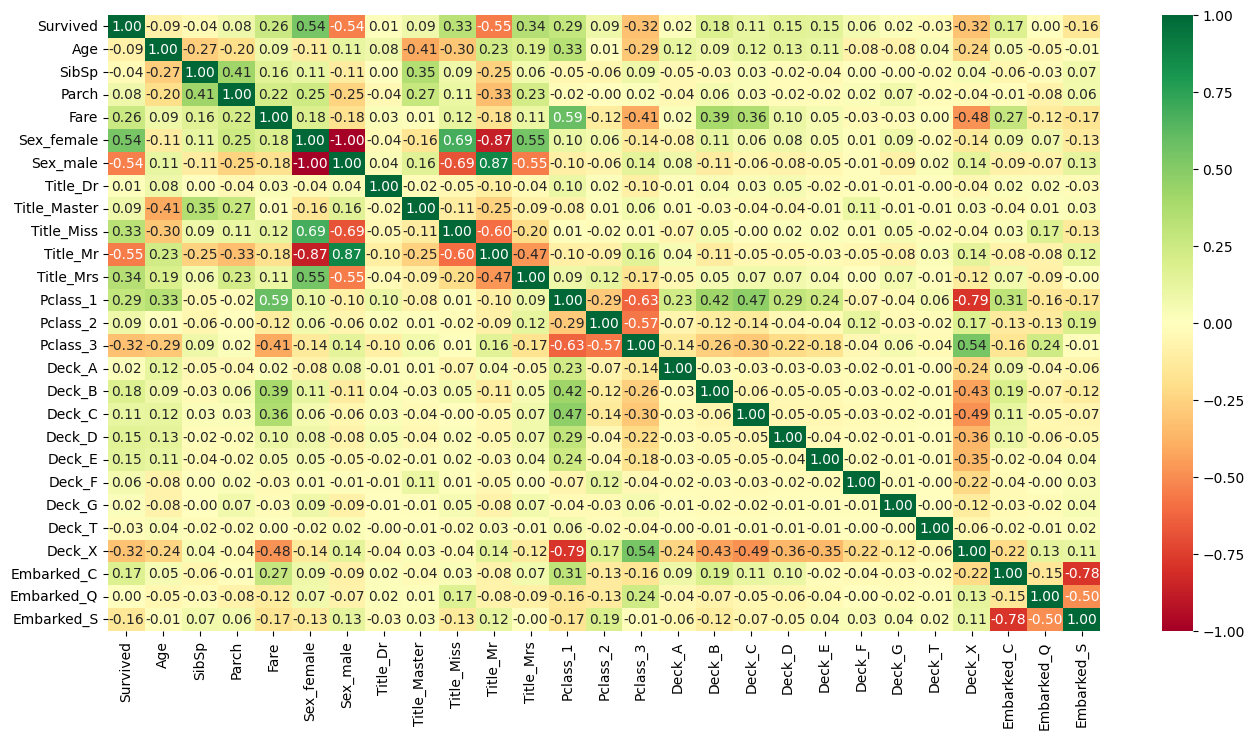

In [28]:
plt.figure(figsize=(16, 8))
sns.heatmap(train.corr(),annot=True,cmap='RdYlGn',fmt=".2f")
plt.show()  

As mentioned above a created a helper which overfits a random forrest to see how much information is the in columns.

In [29]:
GetMaxInformationFromColumns(train[['Survived', 'Parch']])
GetMaxInformationFromColumns(train[['Survived', 'SibSp']])
GetMaxInformationFromColumns(train[['Survived', 'Parch', 'SibSp']])
GetMaxInformationFromColumns(train[['Survived', 'Title_Mr', 'Title_Mrs', 'Title_Miss', 'Title_Master']])
GetMaxInformationFromColumns(train[['Survived', 'Sex_male', 'Sex_female']])
GetMaxInformationFromColumns(train[['Survived', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3']])
GetMaxInformationFromColumns(train[['Survived', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Deck_X']])
GetMaxInformationFromColumns(train[['Survived', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Deck_X', 'SibSp']])
GetMaxInformationFromColumns(train[['Survived', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Deck_X', 'SibSp', 'Parch']])
GetMaxInformationFromColumns(train[['Survived', 'Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Deck_X', 'SibSp', 'Parch', 'Age']])

The accuracy of the random forrest is 0.6307519640852974
The accuracy of the random forrest is 0.632996632996633
The accuracy of the random forrest is 0.6778900112233446
The accuracy of the random forrest is 0.7856341189674523
The accuracy of the random forrest is 0.7867564534231201
The accuracy of the random forrest is 0.7867564534231201
The accuracy of the random forrest is 0.7912457912457912
The accuracy of the random forrest is 0.8114478114478114
The accuracy of the random forrest is 0.8237934904601572
The accuracy of the random forrest is 0.9259259259259259


In [30]:
train_copy=train.copy() #copy of the training dataset as we need the original later on.

The data has to be split again into training an test dataset. It will also be split between 'Survived' column and the other columns.

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

train,test=train_test_split(train_copy,test_size=0.3,random_state=0,stratify=train_copy['Survived'])

train_Y=train[['Survived']]
train = train.drop(columns=['Survived'])
train_X=train[train.columns[:]]
test_Y=test[['Survived']]
test = test.drop(columns=['Survived'])
test_X=test[test.columns[:]]

X=train_copy[train_copy.columns[1:]]
Y=train_copy['Survived']

My first model will be a support vector machine with linear kernel. I am using GridSearchCV to find the best parameters for gamma and C.

In [32]:
model=SVC(kernel='linear')
parameters = {'gamma':[0.1,1,5 ], 'C':[0.1,1,5]}
clf = GridSearchCV(model, parameters)
clf.fit(train_X,train_Y.values.ravel())
prediction = clf.predict(test_X)
#print(clf.cv_results_)
print('The accuracy of the Logistic Regression is',accuracy_score(prediction,test_Y))


The accuracy of the Logistic Regression is 0.8208955223880597


The best values are 1 and 0.1. We can now print the Roc and confusion matrix.

The accuracy of the SVC is 0.8208955223880597


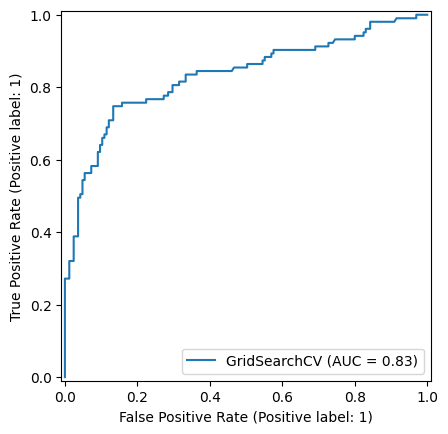

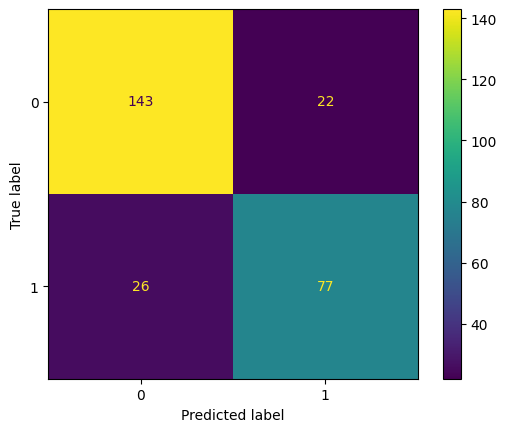

In [33]:
model=SVC(kernel='linear', C=1, gamma = 0.1)
model.fit(train_X,train_Y.values.ravel())
prediction=model.predict(test_X)
print('The accuracy of the SVC is',accuracy_score(prediction,test_Y))
RocCurveDisplay.from_estimator(clf, test_X, test_Y)
cm = confusion_matrix(test_Y, prediction, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

Second model is logistic regression. It shows a very high accuracy.

The accuracy of the Logistic Regression is 0.8544776119402985


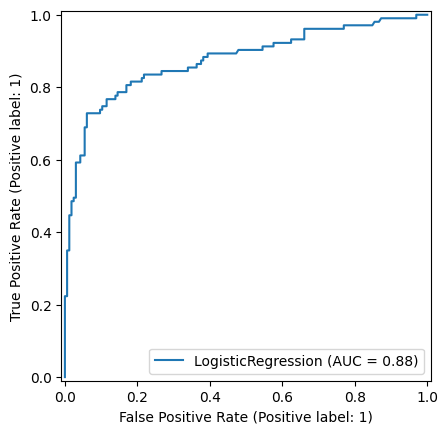

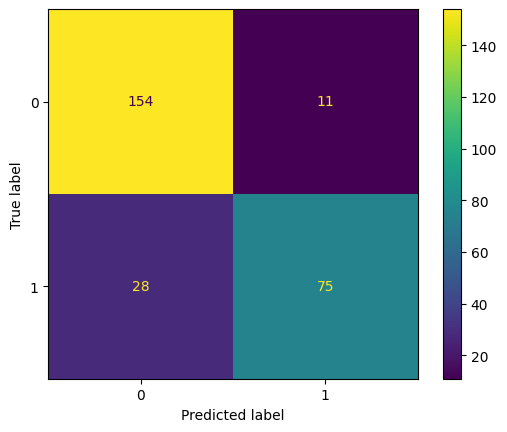

In [34]:
model = LogisticRegression(max_iter=1000)
logResFittedModel = model.fit(train_X,train_Y.values.ravel())
prediction=model.predict(test_X)
print('The accuracy of the Logistic Regression is',accuracy_score(prediction,test_Y))

RocCurveDisplay.from_estimator(logResFittedModel, test_X, test_Y)

cm = confusion_matrix(test_Y, prediction, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()


We can have a look at what was predicted wrong.

In [35]:
print("Wrongly predicted samples averages")

results = test_X.copy()  
results['TrueSurvival'] = test_Y.values  
results['PredictedSurvival'] = prediction   
incorrectPredictions = results[results['TrueSurvival'] != results['PredictedSurvival']]  
cols_to_drop = (col for col in incorrectPredictions.columns if col.startswith('Title_'))  
incorrectPredictions = incorrectPredictions.drop(columns=list(cols_to_drop)) 
print(incorrectPredictions.groupby('Sex_male').mean()[["TrueSurvival",  "PredictedSurvival" ]])
print("======================")
print(incorrectPredictions.mean())
print("======================")
print(incorrectPredictions.groupby('Sex_male').mean())

Wrongly predicted samples averages
          TrueSurvival  PredictedSurvival
Sex_male                                 
False         0.153846           0.846154
True          1.000000           0.000000
Age                  30.410256
SibSp                 0.435897
Parch                 0.282051
Fare                 26.773400
Sex_female            0.333333
Sex_male              0.666667
Pclass_1              0.307692
Pclass_2              0.076923
Pclass_3              0.615385
Deck_A                0.102564
Deck_B                0.025641
Deck_C                0.128205
Deck_D                0.000000
Deck_E                0.025641
Deck_F                0.000000
Deck_G                0.000000
Deck_T                0.000000
Deck_X                0.717949
Embarked_C            0.230769
Embarked_Q            0.128205
Embarked_S            0.641026
TrueSurvival          0.717949
PredictedSurvival     0.282051
dtype: float64
                Age     SibSp     Parch       Fare  Sex_female  Pclas

### Interpretation:
We have already seen before that the dataset does not contain a good indicator for men who survived and women who died. It reflects also in the logistic regression results. The wrongly predicted samples are mostly surviving men who were predicted dead and dead women who were predicted surviving.

And now for a random forrest. Again we use GridSearchCV to find the best parameters for the number of estimators.

The accuracy of the random forrest is 0.832089552238806


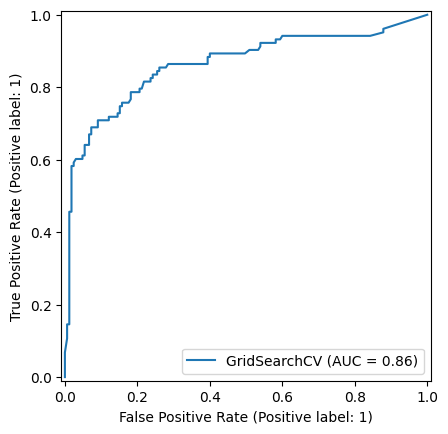

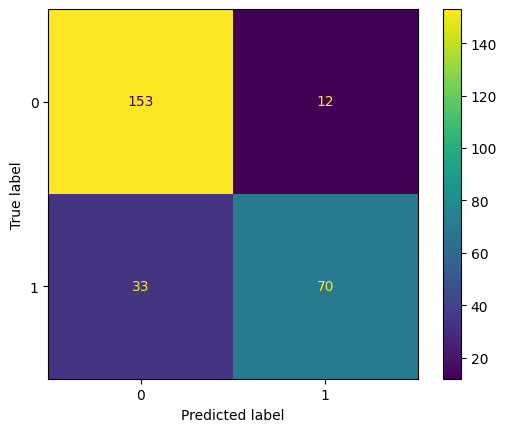

In [43]:
model=RandomForestClassifier()
parameters = {'n_estimators':[5,10,100,500]}
clf = GridSearchCV(model, parameters)
clf.fit(train_X,train_Y.values.ravel())
prediction = clf.predict(test_X)
#print(clf.cv_results_)
print('The accuracy of the random forrest is',accuracy_score(prediction,test_Y))

RocCurveDisplay.from_estimator(clf, test_X, test_Y)
cm = confusion_matrix(test_Y, prediction, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

And now a decision tree. Parameters to optimize are max depth and max number of leaf nodes.

The accuracy of the DecisionTreeClassifier is 0.8246268656716418


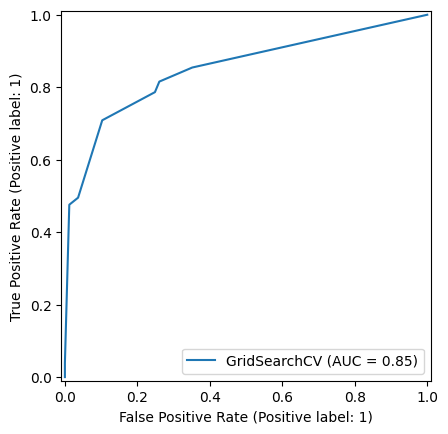

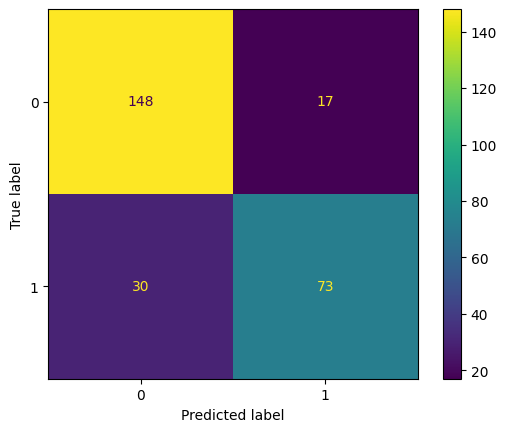

In [44]:
model=DecisionTreeClassifier()
parameters = {'max_depth':[2,3,4,5,6,7],'max_leaf_nodes':[3,10,30]}
clf = GridSearchCV(model, parameters)
clf.fit(train_X,train_Y.values.ravel())
prediction = clf.predict(test_X)
#print(clf.cv_results_)
print('The accuracy of the DecisionTreeClassifier is',accuracy_score(prediction,test_Y))

RocCurveDisplay.from_estimator(clf, test_X, test_Y)
cm = confusion_matrix(test_Y, prediction, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

And also a decision tree using AdaBoost.

The accuracy of the AdaBoostClassifier is 0.7835820895522388


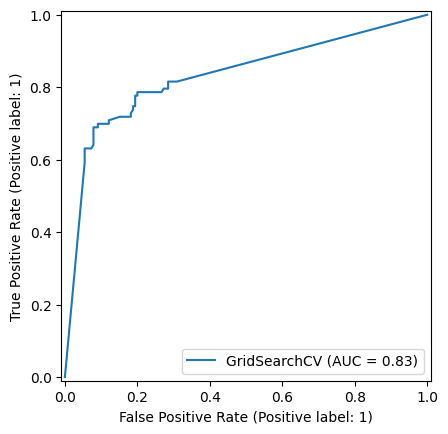

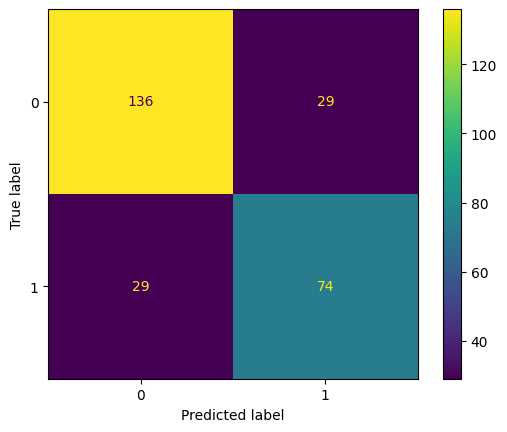

In [42]:
from sklearn.ensemble import AdaBoostClassifier
dtc = DecisionTreeClassifier()
clf = AdaBoostClassifier(estimator=dtc, random_state=0,algorithm='SAMME')
parameters = {'n_estimators':[1,10,100],'learning_rate':[0.1,1.0,10.0]}
clf = GridSearchCV(clf, parameters)
clf.fit(train_X,train_Y.values.ravel())
prediction = clf.predict(test_X)
#print(clf.cv_results_)
print('The accuracy of the AdaBoostClassifier is',accuracy_score(prediction,test_Y))

RocCurveDisplay.from_estimator(clf, test_X, test_Y)
cm = confusion_matrix(test_Y, prediction, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

### Comparison of the models: 
- The most simple approach (logistic regression) showed the best result. My assumption is, it is because of the simplicity of the data set.
- Decision tree, random forrest and support vector machine showed similar results

The data set itself is not perfect for the comparison of models but it is a nice data set to practice EDA.